# 0. Imports, some helper functions

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import gamma
import matplotlib
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

import sys
sys.path.append('./src')
from hierarchical_fisher import FisherTheory

# global param to enable/suppress figure saving
# switch to True to enable saving
g_save_fig = False

In [2]:
# plotting colors (assuming 11 population sizes)
standard_colors = ['cornflowerblue', 'slateblue', 'mediumpurple', 'blueviolet',
                   'purple', 'mediumvioletred', 'palevioletred', 'crimson',
                   'firebrick', 'orangered', 'red']
n_pop_sizes = len(standard_colors)
hierarchical_tc_color = 'cadetblue'
hierarchical_tc_color_iso = 'steelblue'
fixed_width_tc_color = 'darkgreen'
width_samples = 32
power_limit = 5

---

# 1. Schematic figures

### 1.x. Schematic of efficient (vs. inefficient) tuning curves

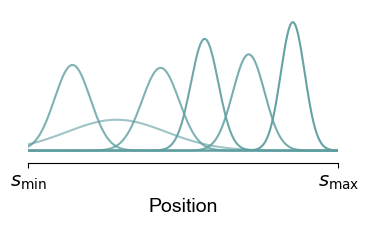

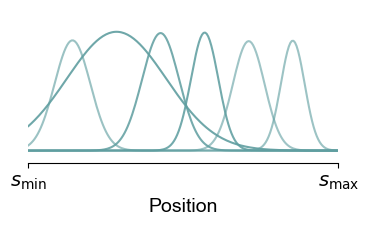

In [3]:
np.random.seed(5)

n_neurons = 8
stim_hits = 200
sigmas = np.random.gamma(6, 0.1/6, size=n_neurons)
efficient_gains = 1 / sigmas
inefficient_gains = np.random.uniform(low=0.8, high=1, size=n_neurons)

centers = np.linspace(0, 1, num=n_neurons)
stims = np.linspace(0, 1, num=stim_hits)

efficient_frs = np.array(
    [[ efficient_gains[j]  * np.exp(-np.power(stims[i] - centers[j], 2) / np.power(sigmas[j], 2)) \
       for i in range(stim_hits) ] for j in range(n_neurons) ])
efficient_frs /= np.max(efficient_frs)
inefficient_frs = np.array(
    [[ inefficient_gains[j] * np.exp(-np.power(stims[i] - centers[j], 2) / np.power(sigmas[j], 2)) \
       for i in range(stim_hits) ] for j in range(n_neurons) ])

def gen_alpha(gain, all_gains, low=0.6, high=0.9):
    alpha = (gain - np.min(all_gains)) / (np.max(all_gains) - np.min(all_gains))
    return (alpha * (high - low)) + low

figs = [ plt.subplots(figsize=(4, 2)) for i in range(2) ]
for i in range(n_neurons):
    if i == 0 or i == n_neurons - 1:
        # skip first and last neuron to make the plots pretty
        continue
    
    efficient_col = matplotlib.colors.colorConverter.to_rgba(
        hierarchical_tc_color, alpha=gen_alpha(efficient_gains[i], efficient_gains[1:-2]))
    figs[0][1].plot(efficient_frs[i], color=efficient_col)
    
    inefficient_col = matplotlib.colors.colorConverter.to_rgba(
        hierarchical_tc_color, alpha=gen_alpha(inefficient_gains[i], inefficient_gains[1:-2]))
    figs[1][1].plot(inefficient_frs[i], color=inefficient_col)
    
def format_ax_and_save(figax, fname):
    fig, ax = figax
    ax.set_ylim((-0.1, 1.1))
    ax.set_xticks([0, stim_hits], ['$s_\min$', '$s_\max$'], fontsize=14)
    ax.set_xlabel('Position', fontsize=14)
    ax.set_xlim((0, stim_hits))
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    if g_save_fig:
        fig.savefig(fname, dpi=300, bbox_inches='tight')

format_ax_and_save(figs[0], 'final_efficient_gain_schematic')
format_ax_and_save(figs[1], 'final_inefficient_gain_schematic')

### 1.x. Schematic of hierarchical vs. fixed-width code

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from scipy.stats import gamma
import matplotlib

def do_it(radii, field_color, thetas, figax, fname):
    fig, ax = figax
    
    ax_inset = ax.inset_axes([1.05, 0, 0.43, 0.43])
    ax_inset.hist(radii.flatten(), color=field_color)
    ax_inset.set_xlim((0, 2))
    ax_inset.set_ylim((0, 40))
    ax_inset.set_yticks([])
    ax_inset.set_xticks([])
    ax_inset.set_xlabel('Width', fontsize=12)
    ax_inset.set_title('Count', fontsize=12)
    ax_inset.spines[['top', 'left', 'right']].set_visible(False)
    
    col = matplotlib.colors.colorConverter.to_rgba(field_color, alpha=0.24)
    for j in range(n_neurons):
        ax.add_patch(Ellipse(centers[j], 
                             radii[j, 0], 
                             radii[j, 1],
                             angle=thetas[j],
                             facecolor=col))
    ax.set_ylim((0, 5))
    ax.set_xlim((0, 5))
    ax.set_xticks([0, 5], ['$s_\min$', '$s_\max$'], fontsize=14)
    ax.set_yticks([0, 5], ['$s_\min$', '$s_\max$'], fontsize=14)
    ax.set_xlabel(r'$s(1)$', fontsize=14)
    ax.set_ylabel(r'$s(2)$', fontsize=14)
    
    if g_save_fig:
        fig.savefig(fname, dpi=300, bbox_inches='tight')

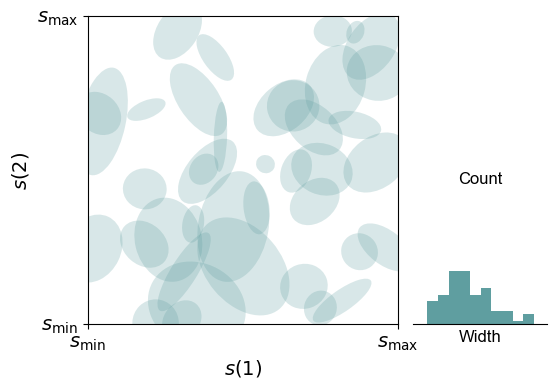

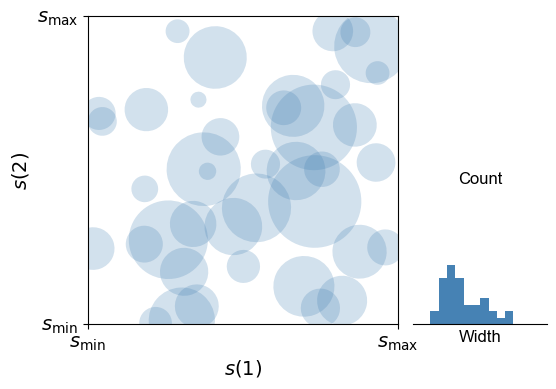

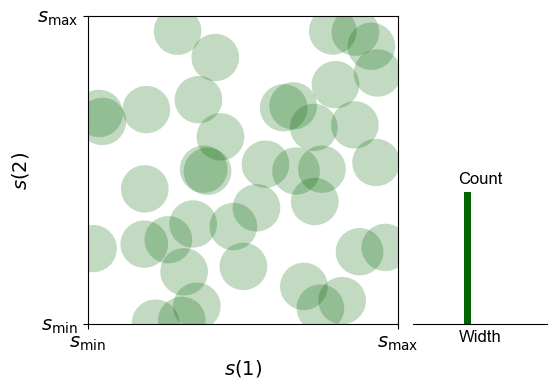

In [5]:
np.random.seed(8)
n_neurons = 40
sig_beta = 1/1.3
colors = [hierarchical_tc_color, hierarchical_tc_color, fixed_width_tc_color]

figs = [ plt.subplots(figsize=(4, 4)) for i in range(3) ]

a_hierarchical_radii = np.random.gamma(6, scale=sig_beta / 6, size=(n_neurons, 2))
fixed_width_radii = sig_beta * np.ones((n_neurons, 2))
centers = np.random.uniform(low=0, high=5, size=(n_neurons, 2))
thetas = np.random.uniform(low=0, high=360, size=n_neurons)
i_hierarchical_radii = np.transpose(
                            np.multiply(np.random.gamma(6, scale=sig_beta / 6, size=n_neurons), 
                                        np.ones((2, n_neurons))),
                            (1, 0))

do_it(a_hierarchical_radii, 
      hierarchical_tc_color, 
      thetas,
      figs[0],
      'hierarchical_code_schematic_anisotropic')
do_it(i_hierarchical_radii, 
      hierarchical_tc_color_iso, 
      thetas,
      figs[1],
      'hierarchical_code_schematic_isotropic')
do_it(fixed_width_radii, 
      fixed_width_tc_color, 
      thetas,
      figs[2],
      'fixed_width_code_schematic')

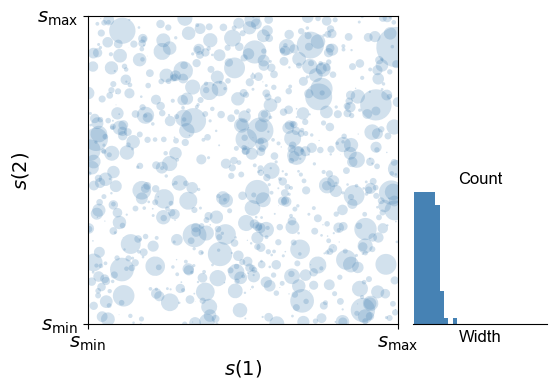

In [6]:
sig_beta = 1/8
n_neurons = 800
centers = np.random.uniform(low=0, high=5, size=(n_neurons, 2))
thetas = np.random.uniform(low=0, high=360, size=n_neurons)
i_hierarchical_radii = np.transpose(
                            np.multiply(np.random.gamma(2, scale=sig_beta / 2, size=n_neurons), 
                                        np.ones((2, n_neurons))),
                            (1, 0))

do_it(i_hierarchical_radii, 
      hierarchical_tc_color_iso, 
      thetas,
      plt.subplots(figsize=(4, 4)),
      'hierarchical_code_schematic_isotropic_b8')

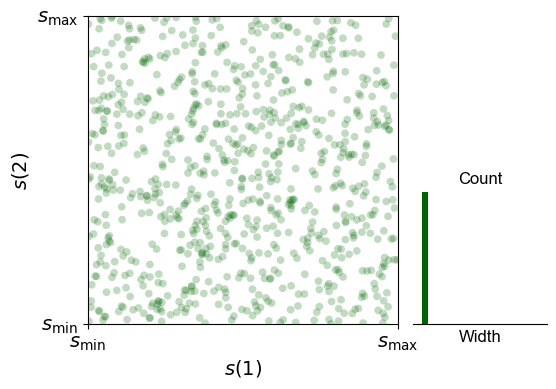

In [7]:
sig_beta = 1/8
n_neurons = 800
centers = np.random.uniform(low=0, high=5, size=(n_neurons, 2))
thetas = np.random.uniform(low=0, high=360, size=n_neurons)
fixed_width_radii = sig_beta * np.ones((n_neurons, 2))

do_it(fixed_width_radii, 
      fixed_width_tc_color, 
      thetas,
      plt.subplots(figsize=(4, 4)),
      'fixed_width_code_schematic_b8')

### 1.x. Schematic of the unbounded and bounded cases

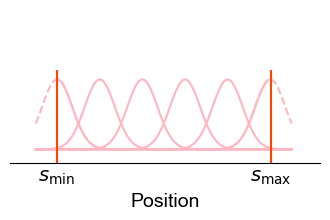

In [8]:
n_neurons = 6
stim_hits = 100
tc_color = 'lightpink'
boundary_color = 'orangered'
sigmas = 0.1 * np.ones(n_neurons)
centers = np.linspace(0, 1, num=n_neurons)
stims = np.linspace(-0.1, 1.1, num=stim_hits)
resps = np.array([[0.5 * np.exp(-np.power(stims[i] - centers[j], 2) / np.power(sigmas[j], 2)) \
                    for i in range(stim_hits)] for j in range(n_neurons)])
fig, ax = plt.subplots(figsize=(4, 2))
for i in range(n_neurons):
    if i == 0 or i == n_neurons - 1:
        ax.plot(resps[i], '--', color=tc_color)
    
    if i == 0:
        ax.plot(np.arange(9, stim_hits), resps[i,9:], color=tc_color)
        continue
    if i == n_neurons - 1:
        ax.plot(np.arange(0, stim_hits - 9), resps[i,:-9], color=tc_color)
        continue
        
    ax.plot(resps[i], color=tc_color)
    
ax.axvline(8, 0, 0.6, color=boundary_color)
ax.axvline(stim_hits - 9, 0, 0.6, color=boundary_color)
ax.set_ylim((-0.1, 1))
ax.set_xticks([8, stim_hits - 9], ['$s_\min$', '$s_\max$'], fontsize=14)
ax.set_xlabel('Position', fontsize=14)
ax.set_xlim((-10, stim_hits + 10))
ax.tick_params(direction='in')
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

if g_save_fig:
    fig.savefig('bounded_assumption_schematic', dpi=300, bbox_inches='tight')

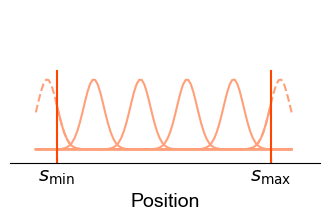

In [9]:
n_neurons = 6
tc_color = 'lightsalmon'
boundary_color = 'orangered'
stim_hits = 100
sigmas = 0.1 * np.ones(n_neurons)
centers = np.linspace(-0.32, 1.32, num=n_neurons)
stims = np.linspace(-0.4, 1.4, num=stim_hits)
resps = np.array([[0.5 * np.exp(-np.power(stims[i] - centers[j], 2) / np.power(sigmas[j], 2)) \
                    for i in range(stim_hits)] for j in range(n_neurons)])
fig, ax = plt.subplots(figsize=(4, 2))
for i in range(n_neurons):
    if i == 0 or i == n_neurons - 1:
        ax.plot(resps[i], '--', color=tc_color)
    
    if i == 0:
        ax.plot(np.arange(8, stim_hits), resps[i,8:], color=tc_color)
        continue
    if i == n_neurons - 1:
        ax.plot(np.arange(0, stim_hits - 8), resps[i,:-8], color=tc_color)
        continue
        
    ax.plot(resps[i], color=tc_color)
    
ax.axvline(8, 0, 0.6, color=boundary_color)
ax.axvline(stim_hits - 9, 0, 0.6, color=boundary_color)
ax.set_ylim((-0.1, 1))
ax.set_xticks([8, stim_hits - 9], ['$s_\min$', '$s_\max$'], fontsize=14)
ax.set_xlabel('Position', fontsize=14)
ax.set_xlim((-10, stim_hits + 10))
ax.tick_params(direction='in')
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

if g_save_fig:
    fig.savefig('unbounded_assumption_schematic', dpi=300, bbox_inches='tight')

---

# 2. Fixed-width code vs. hierarchical code

In [10]:
def plot_sims_and_theory(sims_and_theory_dict,
                         fname,
                         center_range=(0, 1),
                         stim_range=(0, 1),
                         stim_dim=2,
                         fixed_sigma=False,
                         use_log_scale=None,
                         ylim=None,
                         unbounded_theory=None,
                         only_unbounded=False,
                         fig_title=None,
                         subsample_size=None):
    inv_eta = np.power(center_range[1] - center_range[0], stim_dim) / \
        np.power(stim_range[1] - stim_range[0], stim_dim)
    betas = 2 ** np.linspace(0, -power_limit, num=width_samples)
    inv_betas = np.power(betas, -1)
    n_neurons = 100 * np.power(2.0, np.arange(-1, n_pop_sizes - 1))
    
    fig, ax = plt.subplots(figsize=(4, 4))
    for j, (sim, theory) in enumerate(sims_and_theory_dict.values()):
        if unbounded_theory:
            unbounded_theory_prediction = [
                unbounded_theory[j].fi_per_pparam(b, fixed_sigma=fixed_sigma) for b in betas
            ]
            
            ax.plot(unbounded_theory_prediction, 
                    '--', 
                    color='lightsalmon', 
                    label='asymptotic information' if j == 0 else None)
            
            if only_unbounded:
                continue
        
        
        where = np.full(np.transpose(sim, (2, 3, 4, 0, 1)).shape, True)
        if subsample_size:
            idx = np.arange(sim.shape[2])
            np.random.shuffle(idx)
            where[idx[subsample_size:], :, :, :, :] = False
            
        sim_avg = np.sqrt(np.linalg.det(
            np.mean(np.transpose(sim, (2, 3, 4, 0, 1)) * inv_eta, axis=0, where=where)
        )) / n_neurons
    
        for i, n in enumerate(n_neurons):
            col = matplotlib.colors.colorConverter.to_rgba(standard_colors[i], alpha=0.5)

            ax.plot(sim_avg[:, i], '-o', label='${:,}$'.format(int(n)) if j == 0 else None, 
                color=col, markerfacecolor='white', markeredgecolor=col, markersize=4)

        theory_prediction = [
            theory.fi_per_pparam(b, fixed_sigma=fixed_sigma) for b in betas
        ]
        
        ax.plot(theory_prediction, '--', color='black', label='theory' if j == 0 else None)

    ax.set_xticks(np.linspace(0, 32, num=power_limit + 1), list(map(lambda x: "{}".format(int(x)), \
               2 ** np.linspace(0, power_limit, num=power_limit + 1))))
    ax.set_ylabel('Discriminability', fontsize=14)
    xlabel = r'Inverse field size ($\sigma^{-1}$)' if fixed_sigma else r'Inverse mean field size ($\beta^{-1}$)'
    ax.set_xlabel(xlabel, fontsize=14)
    ax.legend(frameon=False, bbox_to_anchor=(1.01, 1), loc='upper left', title='Population size')
    ax.tick_params(direction='in')
    ax.set_xlim((0, 32))
    if ylim:
        ax.set_ylim(ylim)
    if use_log_scale:
        ax.set_yscale('log')
        ax.set_ylim(use_log_scale)
    ax.spines[['right', 'top']].set_visible(False)
    if fig_title:
        ax.set_title(fig_title, fontsize=14)

    if g_save_fig:
        fig.savefig(fname, dpi=300, bbox_inches='tight')

### 2.x Unbounded hierarchical vs. fixed width FI 

#### 2.x.1 Anisotropic vs. fixed width discriminability

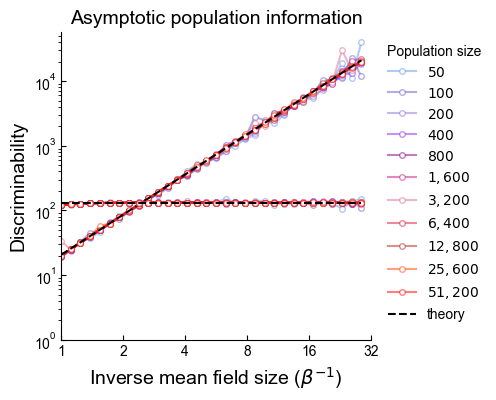

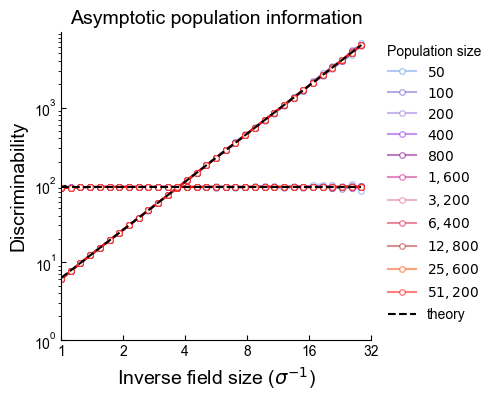

In [18]:
plot_sims_and_theory(
    {
        'efficient' : (np.load('./data/gamma_sims_full_n3p5_ub_eff.npy'),  
                       FisherTheory(2, bounded=False, efficient=True, shape=3.5)),
        'inefficient' : (np.load('./data/gamma_sims_full_n3p5_ub_ineff.npy'), 
                         FisherTheory(2, bounded=False, shape=3.5))
    },
    'hierarchical_ineffficient_efficient_sims_theory_gamma_3p5',
    center_range=(0, 6),
    stim_range=(2.5, 3.5),
    use_log_scale=True,
    fig_title='Asymptotic population information'
)
plot_sims_and_theory(
    {
        'efficient' : (np.load('./data/ftc_sims_full_ub_eff.npy'),  
                       FisherTheory(2, bounded=False, efficient=True)),
        'inefficient' : (np.load('./data/ftc_sims_full_ub_ineff.npy'), 
                         FisherTheory(2, bounded=False))
    },
    'fixed_width_efficient_inefficient_sims_theory',
    fixed_sigma=True,
    center_range=(0, 6),
    stim_range=(2.5, 3.5),
    use_log_scale=True,
    fig_title='Asymptotic population information'
)

#### 2.x.1 Isotropic vs. fixed width discriminability

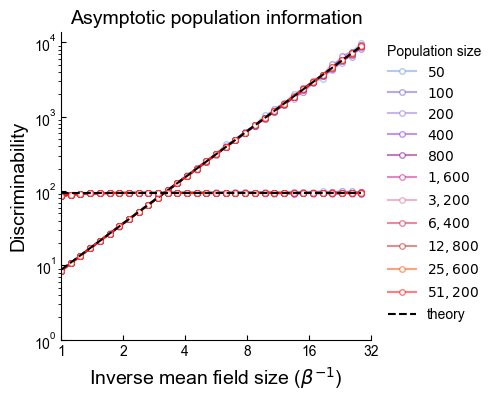

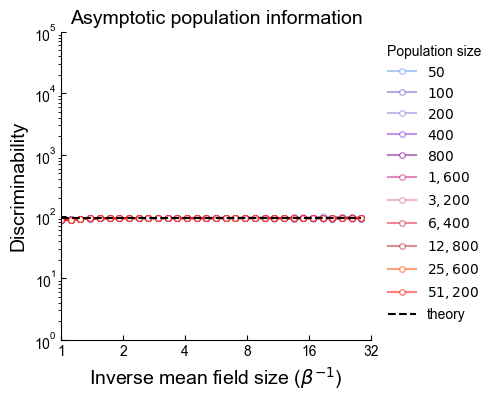

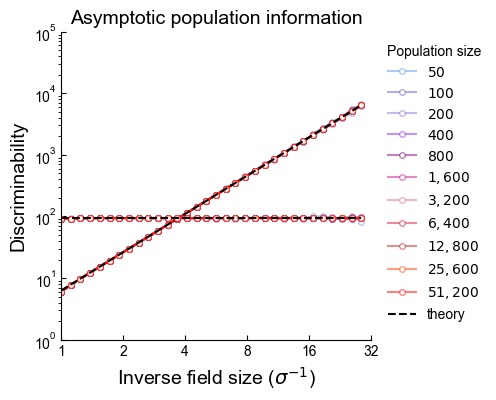

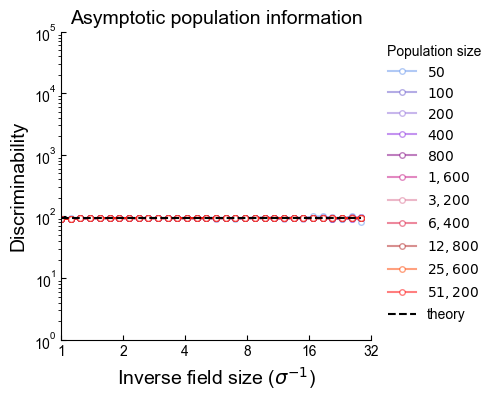

In [15]:
plot_sims_and_theory(
    {
        'efficient' : (np.load('./data/gamma_sims_full_n10_ub_eff_iso.npy'),  
                       FisherTheory(2, bounded=False, efficient=True, anisotropic=False)),
        'inefficient' : (np.load('./data/gamma_sims_full_n10_ub_ineff_iso.npy'), 
                         FisherTheory(2, bounded=False, anisotropic=False))
    },
    'hierarchical_efficient_inefficient_sims_theory_iso',
    center_range=(0, 6),
    stim_range=(2.5, 3.5),
    use_log_scale=True,
    fig_title='Asymptotic population information'
)
plot_sims_and_theory(
    {
        'inefficient' : (np.load('./data/gamma_sims_full_n10_ub_ineff_iso.npy'), 
                         FisherTheory(2, bounded=False, anisotropic=False))
    },
    'hierarchical_inefficient_sims_theory_iso',
    center_range=(0, 6),
    stim_range=(2.5, 3.5),
    use_log_scale=(1, 10 ** 5),
    fig_title='Asymptotic population information'
)
plot_sims_and_theory(
    {
        'efficient' : (np.load('./data/ftc_sims_full_ub_eff.npy'),  
                       FisherTheory(2, bounded=False, efficient=True)),
        'inefficient' : (np.load('./data/ftc_sims_full_ub_ineff.npy'), 
                         FisherTheory(2, bounded=False))
    },
    'fixed_width_efficient_inefficient_sims_theory',
    fixed_sigma=True,
    center_range=(0, 6),
    stim_range=(2.5, 3.5),
    use_log_scale=(1, 10 ** 5),
    fig_title='Asymptotic population information'
)
plot_sims_and_theory(
    {
        'inefficient' : (np.load('./data/ftc_sims_full_ub_ineff.npy'), 
                         FisherTheory(2, bounded=False))
    },
    'fixed_width_inefficient_sims_theory',
    fixed_sigma=True,
    center_range=(0, 6),
    stim_range=(2.5, 3.5),
    use_log_scale=(1, 10 ** 5),
    fig_title='Asymptotic population information'
)

### 2.x Linear discriminability invariant to simulated sample size

Toggle sample size with `subsample_size` arg

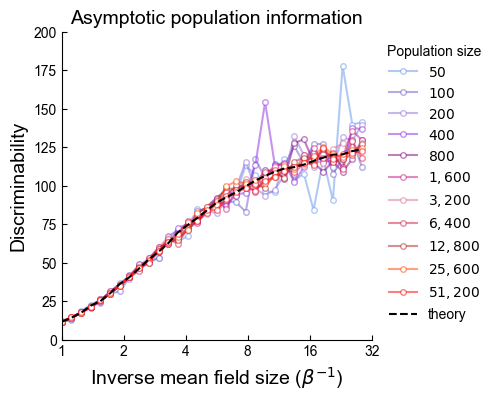

In [44]:
plot_sims_and_theory(
    {
        'inefficient' : (np.load('./data/gamma_sims_full_n3p5_ineff.npy'), 
                         FisherTheory(2, bounded=True, shape=3.5, bounded_kw={'iters' : 10000}))
    },
    'hierarchical_inefficient_sims_theory_n3p5_p50',
    ylim=(0, 200),
    fig_title='Asymptotic population information',
    subsample_size=50
)

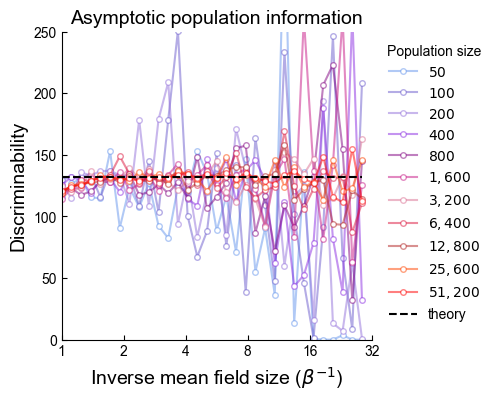

In [79]:
plot_sims_and_theory(
    {
        'inefficient' : (np.load('./data/gamma_sims_full_n3p5_ub_ineff.npy'), 
                         FisherTheory(2, bounded=False, shape=3.5))
    },
    'hierarchical_inefficient_sims_theory_ub_n3p5_p10',
    center_range=(0, 6),
    stim_range=(2.5, 3.5),
    ylim=(0, 250),
    fig_title='Asymptotic population information',
    subsample_size=10
)

### 2.xx Isotropic vs. anisotropic asymptotic information

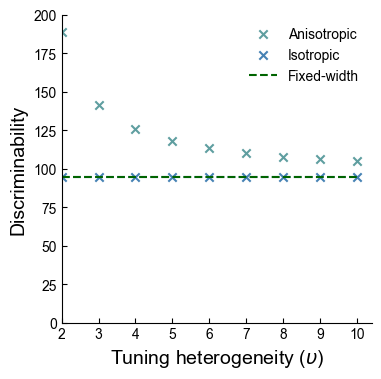

In [17]:
anisotropic_asymptotic = [ FisherTheory(2, bounded=False, shape=i).fi_per_pparam(1) for i in np.arange(2, 11) ]
anisotropic_interp = [ 
    FisherTheory(2, bounded=False, shape=i).fi_per_pparam(1) for i in np.linspace(2, 10, num=100) 
]
isotropic_asymptotic = [ 
    FisherTheory(2, bounded=False, anisotropic=False, shape=i).fi_per_pparam(1) for i in np.arange(2, 11) 
]
isotropic_interp = [ 
    FisherTheory(2, 
                 bounded=False, 
                 anisotropic=False, 
                 shape=i).fi_per_pparam(1) for i in np.linspace(2, 10, num=100) 
]
fw_interp = [ 
    FisherTheory(2, bounded=False).fi_per_pparam(1, fixed_sigma=True) for i in np.linspace(2, 10, num=100) 
]

fig, ax = plt.subplots(figsize=(4, 4))
# ax.plot(np.linspace(2, 10, num=100), anisotropic_interp, '--', color=hierarchical_tc_color)
ax.scatter(np.arange(2, 11), 
           anisotropic_asymptotic,
           marker='x',
           facecolors=hierarchical_tc_color, 
           label='Anisotropic')
ax.plot(np.linspace(2, 10, num=100), isotropic_interp, '--', color='steelblue')
ax.scatter(np.arange(2, 11), 
           isotropic_asymptotic, 
           marker='x',
           facecolors='steelblue', 
           label='Isotropic')
ax.plot(np.linspace(2, 10, num=100), fw_interp, '--', color=fixed_width_tc_color, label='Fixed-width')
ax.set_ylim((0, 200))
ax.set_xticks(np.arange(2, 11))
ax.set_xlim((2, 10.4))
ax.tick_params(direction='in')
ax.set_xlabel(r'Tuning heterogeneity ($\upsilon$)', fontsize=14)
ax.set_ylabel('Discriminability', fontsize=14)
ax.spines[['right', 'top']].set_visible(False)
ax.legend(frameon=False)

if g_save_fig:
    fig.savefig('ani_vs_iso_asymptotic_information', dpi=300, bbox_inches='tight')

---

# 3. Exploring boundary effects

### 3.1 Efficient and inefficient cases

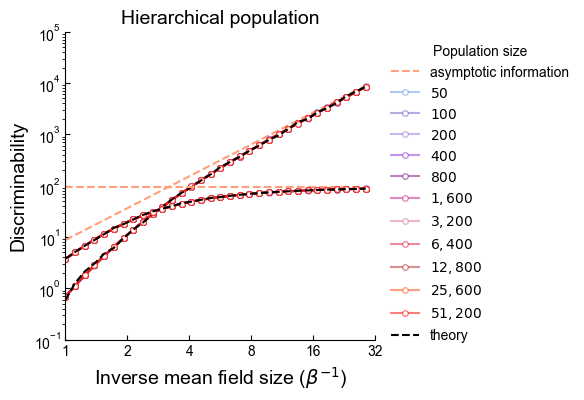

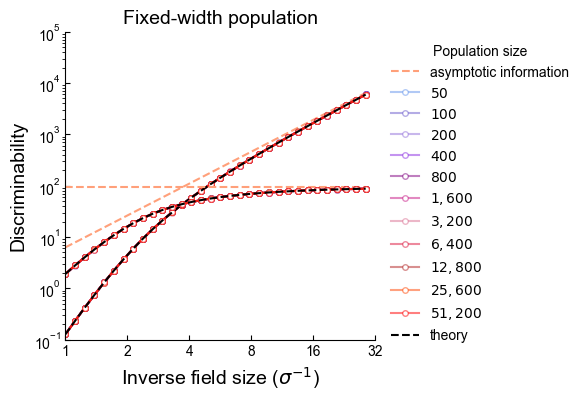

In [19]:
plot_sims_and_theory(
    {
        'efficient' : (np.load('./data/gamma_sims_full_n10_eff_iso.npy'),  
                       FisherTheory(2, bounded=True, efficient=True, anisotropic=False)),
        'inefficient' : (np.load('./data/gamma_sims_full_n10_ineff_iso.npy'), 
                         FisherTheory(2, bounded=True, anisotropic=False))
    },
    'hierarchical_efficient_inefficient_sims_theory_bounded_iso_onlyub',
    use_log_scale=(10 ** -1, 10 ** 5),
    unbounded_theory=[FisherTheory(2, efficient=True, anisotropic=False), FisherTheory(2, anisotropic=False)],
    only_unbounded=False,
    fig_title='Hierarchical population'
)
plot_sims_and_theory(
    {
        'efficient' : (np.load('./data/ftc_sims_full_eff.npy'),  
                       FisherTheory(2, bounded=True, efficient=True)),
        'inefficient' : (np.load('./data/ftc_sims_full_ineff.npy'), 
                         FisherTheory(2, bounded=True))
    },
    'fixed_width_efficient_inefficient_sims_theory_bounded_onlyub',
    fixed_sigma=True,
    use_log_scale=(10 ** -1, 10 ** 5),
    unbounded_theory=[FisherTheory(2, efficient=True), FisherTheory(2)],
    only_unbounded=False,
    fig_title='Fixed-width population'
)

### 3.2 All cases separately

/var/folders/qx/cpmlftn95sx55lbfyq9lwqyw0000gp/T/ipykernel_34898/4003932978.py:57: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim((0, 10 ** 5))


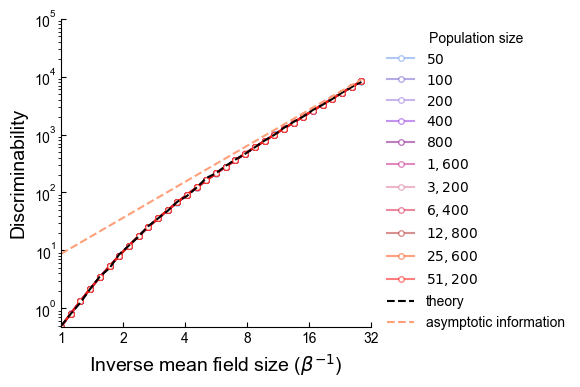

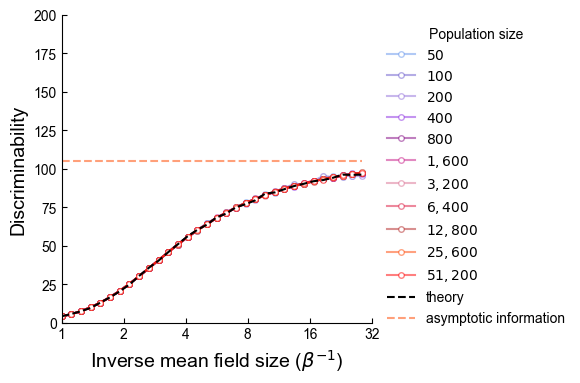

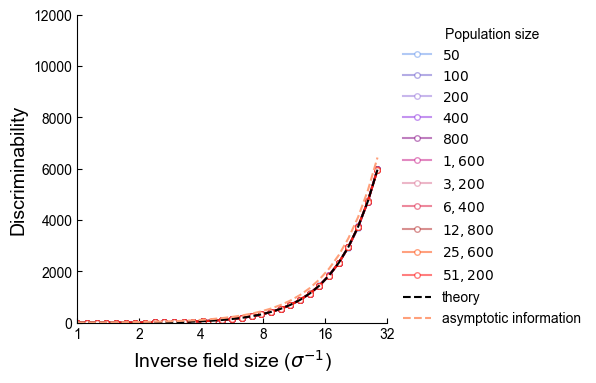

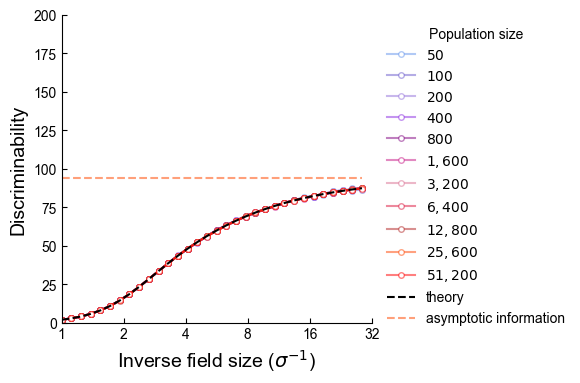

In [48]:
plot_sims_and_theory(
    {
        'efficient' : (np.load('./data/gamma_sims_full_n10_eff.npy'),  
                       FisherTheory(2, bounded=True, efficient=True)),
    },
    'hierarchical_efficient_sims_theory_bounded',
    ylim=(0, 12000),
    use_log_scale=True,
    unbounded_theory=[FisherTheory(2, efficient=True)]
)
plot_sims_and_theory(
    {
        'inefficient' : (np.load('./data/gamma_sims_full_n10_ineff.npy'), 
                         FisherTheory(2, bounded=True))
    },
    'hierarchical_inefficient_sims_theory_bounded',
    ylim=(0, 200),
    unbounded_theory=[FisherTheory(2)]
)
plot_sims_and_theory(
    {
        'efficient' : (np.load('./data/ftc_sims_full_eff.npy'),  
                       FisherTheory(2, bounded=True, efficient=True)),
    },
    'ftc_efficient_sims_theory_bounded',
    fixed_sigma=True,
    ylim=(0, 12000),
    unbounded_theory=[FisherTheory(2, efficient=True)]
)
plot_sims_and_theory(
    {
        'inefficient' : (np.load('./data/ftc_sims_full_ineff.npy'), 
                         FisherTheory(2, bounded=True))
    },
    'ftc_inefficient_sims_theory_bounded',
    fixed_sigma=True,
    ylim=(0, 200),
    unbounded_theory=[FisherTheory(2)]
)

In [20]:
from scipy.optimize import minimize_scalar

fi_bounded = FisherTheory(2, bounded=True, 
                          bounded_kw={'iters' : 10000, 'stabilize' : True, 'analytic_s' : True})
width_samples = 32
power_limit = 5
widths = 2 ** np.linspace(0, -power_limit, num=width_samples)
rel_error = np.zeros(width_samples)
const = 2 * np.pi

for i, beta in enumerate(widths):
    bounds = (0, 4 * beta)
    res = minimize_scalar(
        lambda L : (((np.abs(fi_bounded.L_bounded_is(L, beta) - const) / const) - 0.05) ** 2),
        bounds=bounds)
    rel_error[i] = res.x

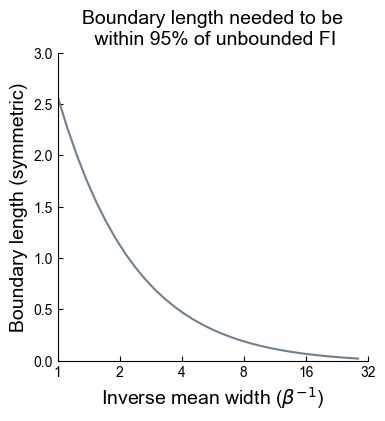

In [21]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(rel_error, color='slategray', label='$L$')
ax.set_ylabel('Boundary length (symmetric)', fontsize=14)
ax.set_xlabel(r'Inverse mean width ($\beta^{-1}$)', fontsize=14)
ax.set_xticks(np.linspace(0, 32, num=power_limit + 1), list(map(lambda x: "{}".format(int(x)), \
               2 ** np.linspace(0, power_limit, num=power_limit + 1))))
ax.set_xlim((0, 32))
ax.tick_params(direction='in')
ax.set_ylim((0, 3))
ax.spines[['right', 'top']].set_visible(False)
ax.set_title('Boundary length needed to be\n within 95% of unbounded FI', fontsize=14)

if g_save_fig:
    fig.savefig('boundary_effect_strength', dpi=300, bbox_inches='tight')

---

# 4. Non-linear averaging demonstration

In [24]:
# Make non-linear averaging demonstration plots
import sys
sys.path.append('./src')
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from hierarchical_fisher import FisherTheory
from matplotlib import rc
import matplotlib
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

def do_it(fname, 
          theory=None, 
          width_samples=32, 
          power_limit=5, 
          stim_range=(0, 1), 
          center_range=(0, 1), 
          stim_dim=2,
          n_pop_sizes=11,
          sig_samp=None,
          ylim=None,
          fsize=4,
          normalize_n=1):
    marker_size = 2 if fsize < 4 else 4
    figs = [ plt.subplots(figsize=(fsize, fsize), nrows=1, ncols=1) for i in range(4) ]
    inv_eta = np.power(center_range[1] - center_range[0], stim_dim) / \
        np.power(stim_range[1] - stim_range[0], stim_dim)
    betas = 2 ** np.linspace(0, -power_limit, num=width_samples)
    inv_betas = np.power(betas, -1)
    n_neurons = 100 * np.power(2.0, np.arange(-1, n_pop_sizes - 1))
    
    if normalize_n:
        finfos = np.transpose(np.load(fname) / np.power(n_neurons, normalize_n), (2, 3, 4, 0, 1)) * inv_eta
    else:
        finfos = np.transpose(np.load(fname), (2, 3, 4, 0, 1)) * inv_eta
    
    linear_mean = np.sqrt(np.linalg.det(np.mean(finfos, axis=0))) 
    nonlinear_mean = np.nanmean(np.sqrt(np.linalg.det(finfos)), axis=0) 
    
    covs = np.array([[np.cov([
        finfos[:, i, j, 0, 0].flatten(), 
        finfos[:, i, j, 0, 1].flatten(), 
        finfos[:, i, j, 1, 0].flatten(),
        finfos[:, i, j, 1, 1].flatten() 
    ]) for i in range(width_samples) ] for j in range(n_pop_sizes) ])
    print(covs.shape)
    
    for i, n in enumerate(n_neurons):
        col = matplotlib.colors.colorConverter.to_rgba(standard_colors[i], alpha=0.5)

        figs[0][1].plot(nonlinear_mean[:, i], '-o', label='${:,}$'.format(int(n)), 
            color=col, markerfacecolor='white', markeredgecolor=col, markersize=marker_size)
        figs[1][1].plot(linear_mean[:, i], '-o', label='${:,}$'.format(int(n)), 
            color=col, markerfacecolor='white', markeredgecolor=col, markersize=marker_size)
        
        var_part = np.divide(
            0.5 * (0.25 * (covs[i, :, 0, 0] + covs[i, :, -1, -1] - 2 * covs[i, :, 1, -1]) + covs[i, :, 1, 2]),
        linear_mean[:, i])
        #var_part = \
        #    covs[i, :, 0, 0] + covs[i, :, -1, -1] - 2 * covs[i, :, 1, -1] + 4 * covs[i, :, 1, 2]
        figs[2][1].plot(var_part, '-o', label='${:,}$'.format(int(n)), 
            color=col, markerfacecolor='white', markeredgecolor=col, markersize=marker_size)
        
        taylor_appx = linear_mean[:, i] - var_part
        figs[3][1].plot(taylor_appx, '-o', label='${:,}$'.format(int(n)), 
            color=col, markerfacecolor='white', markeredgecolor=col, markersize=marker_size)
    
    if theory:
        theory_prediction = [
            theory.fi_per_pparam(b, fixed_sigma='ftc' in fname) for b in betas
        ]
        figs[0][1].plot(theory_prediction, '--', color='black', label='theory')
        figs[1][1].plot(theory_prediction, '--', color='black', label='theory')
        figs[3][1].plot(theory_prediction, '--', color='black', label='theory')
        
    def format_fig(figax, ylabel, title, figfname, ylim=None, legend=True, sig_samp=None):
        fig, ax = figax
        ax.set_xticks(np.linspace(0, 32, num=power_limit + 1), list(map(lambda x: "{}".format(int(x)), \
                   2 ** np.linspace(0, power_limit, num=power_limit + 1))))
        ax.set_ylabel(ylabel, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r'Inverse mean widths ($\beta^{-1}$)', fontsize=14)
        if legend:
            ax.legend(frameon=False, bbox_to_anchor=(1.01, 1), loc='upper left', title='Population size')
        ax.tick_params(direction='in')
        ax.set_xlim((0, 32))
        # ax.annotate(sig_samp, xytext=(8, ylim[1] / 10))
        if ylim:
            ax.set_ylim(ylim)
            #if squash:
            #    half_pt = int(ylim[1] / 2)
            #    ax.set_yticks([0, half_pt, ylim[1]], ['0', str(half_pt), str(ylim[1])])
        
        ax.spines[['right', 'top']].set_visible(False)
        
        fig_base_name = '{}__{}_sqsh' if fsize < 4 else '{}__{}'
        
        if g_save_fig:
            fig.savefig(fig_base_name.format(figfname, fname.split('/')[-1][:-4]), dpi=300, bbox_inches='tight')
    
    fig_fname_template = '{}_nonorm' if not normalize_n else '{}_norm' + str(normalize_n)
    format_fig(figs[0], 'Discriminability', 'Zhang et al., 2023 (nonlinear avg.) \n (replicated)', 
               fig_fname_template.format('nonlinear'), ylim=ylim, sig_samp=sig_samp)
    format_fig(figs[1], 'Discriminability', r'Our measure (linear avg.)', 
               fig_fname_template.format('linear'), ylim=ylim, sig_samp=sig_samp)
    # figs[2][1].set_yscale('log')
    format_fig(figs[2], 'Variance', 'Variance part', fig_fname_template.format('varpart'), legend=True, ylim=ylim)
    format_fig(figs[3], 'Discriminability', 'Taylor approximation', 
               fig_fname_template.format('taylorappx'), ylim=ylim)

/var/folders/qx/cpmlftn95sx55lbfyq9lwqyw0000gp/T/ipykernel_58091/395557797.py:38: RuntimeWarning: invalid value encountered in sqrt
  nonlinear_mean = np.nanmean(np.sqrt(np.linalg.det(finfos)), axis=0)


(11, 32, 4, 4)


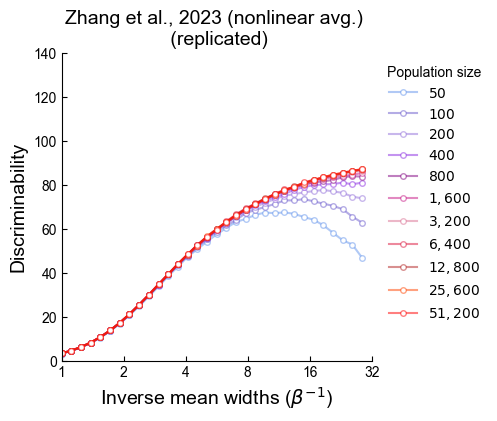

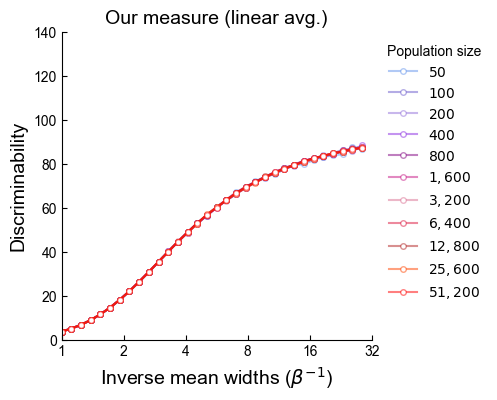

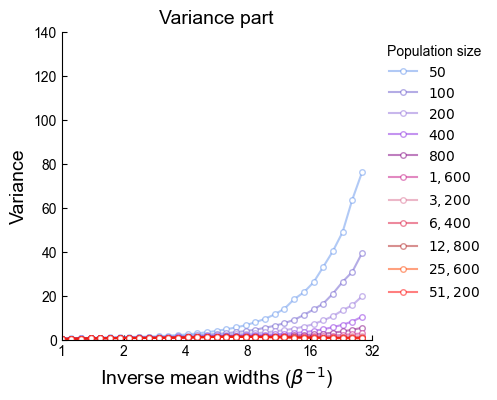

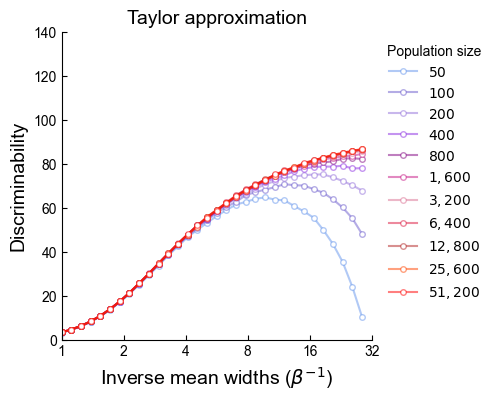

In [25]:
#colors = ['cornflowerblue', 'slateblue', 'mediumpurple', 'blueviolet',
#          'purple', 'mediumvioletred', 'palevioletred', 'crimson',
#          'firebrick', 'orangered', 'red']

theory = FisherTheory(2, bounded=True)
do_it('./data/gamma_sims_full_n10_ineff_iso.npy', 
      sig_samp=r'$\sigma_{n,i} \sim$ Exp($\beta$))',
      ylim=(0, 140))  

---

## Supplementary Information: Information variability in the unbounded and bounded cases

In [28]:
n_neurons = 100 * np.power(2.0, np.arange(-1, n_pop_sizes - 1))
power_limit = 5
n_samples = 1000
betas = 2 ** np.linspace(0, -power_limit, num=16)
cutoff = 6

def diff_variabilities(fname):
    s_dep_cov_part = np.zeros((len(n_neurons), len(betas)))
    s_avg_cov_part = np.zeros_like(s_dep_cov_part)
    total_var = np.zeros_like(s_avg_cov_part)
    
    figaxs = [plt.subplots(figsize=(4,4)) for i in range(3)]
    res = np.load('./data/{fname}_unpacked51200.npy'.format(fname=fname))
    for i, n in enumerate(n_neurons):
        for j, w in enumerate(betas):
            res_w = res[:, :, :int(n), :, j]
            res_avg_across_omega = np.mean(res_w, axis=-2)

            # var in p(s)
            cov_diff = np.var(res_avg_across_omega[0, 0, :] - res_avg_across_omega[1, 1, :])
            cov_od = np.var([res_avg_across_omega[0, 1, :]])
            s_dep_cov_part[i, j] = cov_diff + 4 * cov_od

            # var in p(omega), averaged over s
            cov_diff = np.mean([np.var(res_w[0, 0, :int(n), s] - res_w[1, 1, :int(n), s]) \
                                for s in range(n_samples)])
            cov_od = np.mean([np.var(res_w[0, 1, :int(n), s]) for s in range(n_samples)]) 
            s_avg_cov_part[i, j] = (cov_diff + 4 * cov_od) / n

            total_var[i, j] = (s_dep_cov_part[i, j] + s_avg_cov_part[i, j]) / \
                (8 * np.sqrt(np.linalg.det(np.mean(res_avg_across_omega, axis=-1))))
    
        col = matplotlib.colors.colorConverter.to_rgba(standard_colors[i], alpha=0.5)
        if i == (len(n_neurons) - 1):
            figaxs[0][1].plot(s_dep_cov_part[i], '-o', label='${:,}$'.format(int(n)), 
                color=col, markerfacecolor='white', markeredgecolor=col)
        figaxs[1][1].plot(s_avg_cov_part[i], '-o', label='${:,}$'.format(int(n)), 
            color=col, markerfacecolor='white', markeredgecolor=col)
        figaxs[2][1].plot(total_var[i], '-o', label='${:,}$'.format(int(n)), 
            color=col, markerfacecolor='white', markeredgecolor=col)
        
    def format_fig(figax, ylabel, title, ylim=None, legend=True, sig_samp=None):
        fig, ax = figax
        ax.set_xticks(np.linspace(0, 32, num=power_limit + 1), list(map(lambda x: "{}".format(int(x)), \
                   2 ** np.linspace(0, power_limit, num=power_limit + 1))))
        ax.set_ylabel(ylabel, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r'Inverse mean widths ($\beta^{-1}$)', fontsize=14)
        if legend:
            ax.legend(frameon=False, bbox_to_anchor=(1.01, 1), loc='upper left', title='Population size')
        ax.tick_params(direction='in')
        ax.set_xlim((0, 16))
        if ylim:
            ax.set_ylim(ylim)
            #if squash:
            #    half_pt = int(ylim[1] / 2)
            #    ax.set_yticks([0, half_pt, ylim[1]], ['0', str(half_pt), str(ylim[1])])
        
        ax.spines[['right', 'top']].set_visible(False)
        
        # fig_base_name = '{}__{}_sqsh' if fsize < 4 else '{}__{}'
        # fig.savefig(fig_base_name.format(figfname, fname.split('/')[-1][:-4]), dpi=300, bbox_inches='tight')
    
    format_fig(figaxs[0], 'Boundary effect variability', 
               'blah')
    format_fig(figaxs[1], 'Population-size dependent variability', 
               'blah')
    format_fig(figaxs[2], 'Overall variability', 'Variance part', legend=True)
    
    return s_dep_cov_part, s_avg_cov_part, total_var

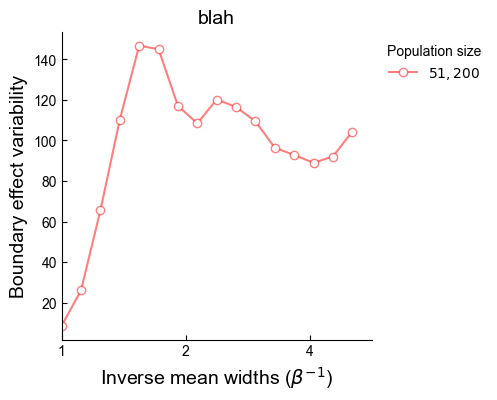

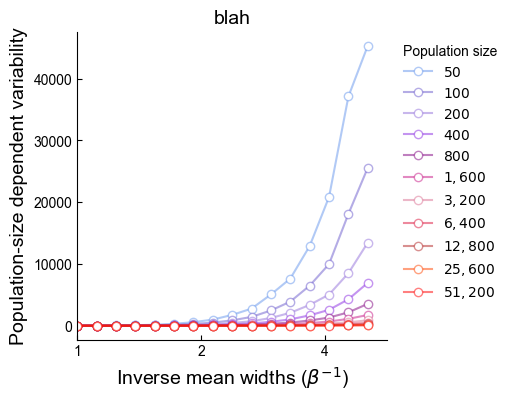

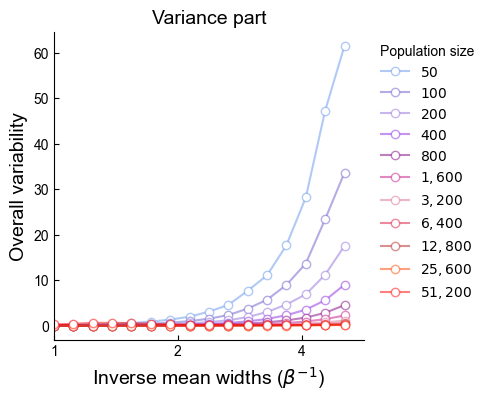

In [29]:
s_dep, s_avg, total = diff_variabilities('gamma_sims_full_n10_ineff')

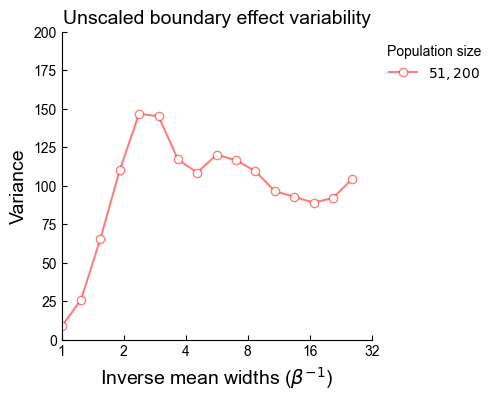

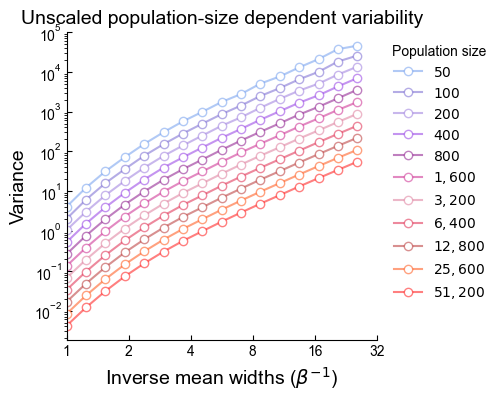

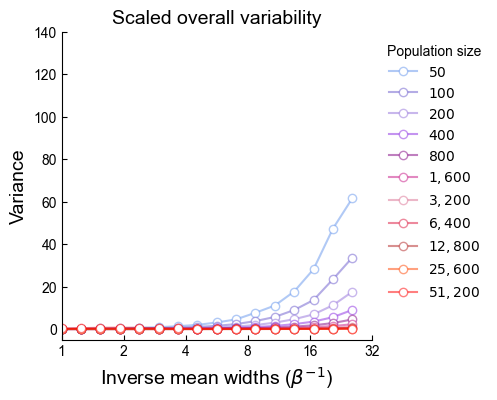

In [56]:
figaxs = [plt.subplots(figsize=(4,4)) for i in range(3)]
for i, n in enumerate(n_neurons):
    col = matplotlib.colors.colorConverter.to_rgba(standard_colors[i], alpha=0.5)
    if i == (len(n_neurons) - 1):
        figaxs[0][1].plot(s_dep[i], '-o', label='${:,}$'.format(int(n)), 
            color=col, markerfacecolor='white', markeredgecolor=col)
    figaxs[1][1].plot(s_avg[i], '-o', label='${:,}$'.format(int(n)), 
        color=col, markerfacecolor='white', markeredgecolor=col)
    figaxs[2][1].plot(total[i], '-o', label='${:,}$'.format(int(n)), 
        color=col, markerfacecolor='white', markeredgecolor=col)

def format_fig(figax, ylabel, title, figfname, ylim=None, legend=True, sig_samp=None):
    fig, ax = figax
    ax.set_xticks(np.linspace(0, 16, num=power_limit + 1), list(map(lambda x: "{}".format(int(x)), \
               2 ** np.linspace(0, power_limit, num=power_limit + 1))))
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(r'Inverse mean widths ($\beta^{-1}$)', fontsize=14)
    if legend:
        ax.legend(frameon=False, bbox_to_anchor=(1.01, 1), loc='upper left', title='Population size')
    ax.tick_params(direction='in')
    ax.set_xlim((0, 16))
    if ylim:
        ax.set_ylim(ylim)

    ax.spines[['right', 'top']].set_visible(False)

    if g_save_fig:
        fig.savefig('{}__{}'.format(figfname, 'gamma_sims_full_n10_ineff'), dpi=300, bbox_inches='tight')

format_fig(figaxs[0], 'Variance', 'Unscaled boundary effect variability', 'bndry_eff_varpart', ylim=(0, 200))
figaxs[1][1].set_yscale('log')
format_fig(figaxs[1], 'Variance', 'Unscaled population-size dependent variability', 'n_scale_varpart')
format_fig(figaxs[2], 'Variance', 'Scaled overall variability', 'total_var', ylim=(-5, 140), legend=True)

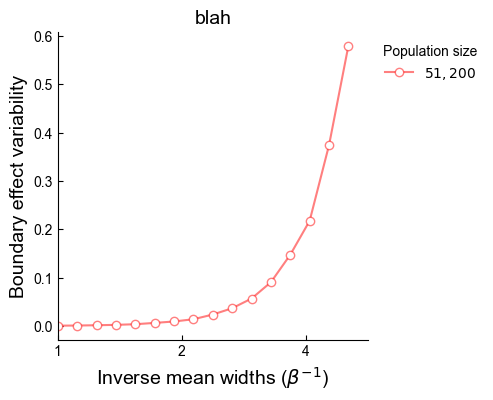

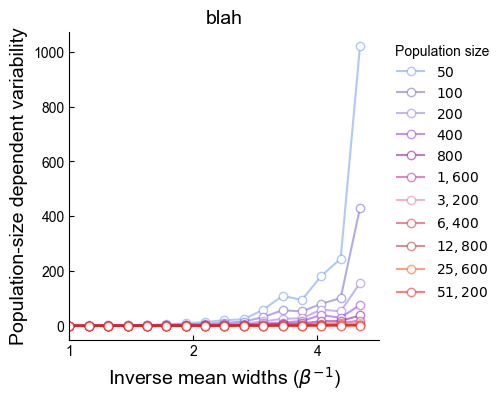

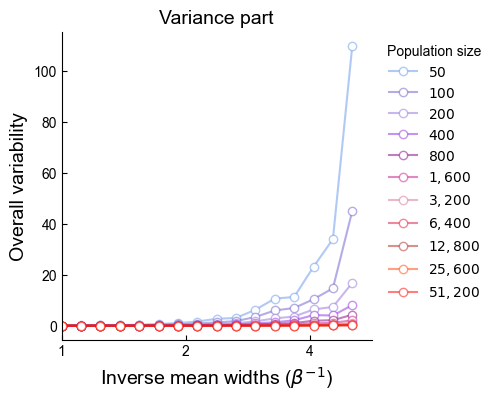

In [30]:
s_depub, s_avgub, totalub = diff_variabilities('gamma_sims_full_n10_ub_ineff')

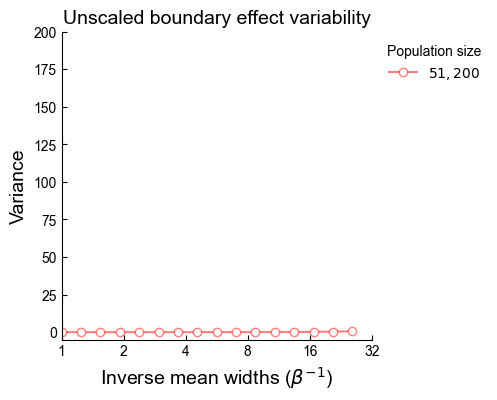

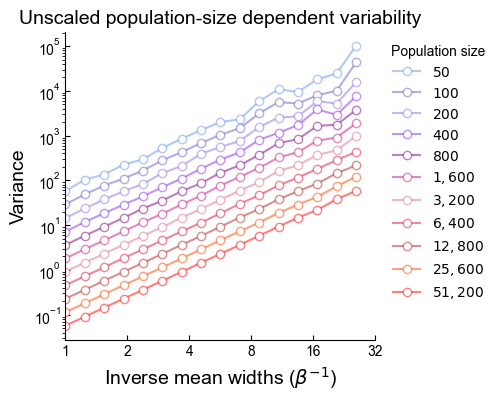

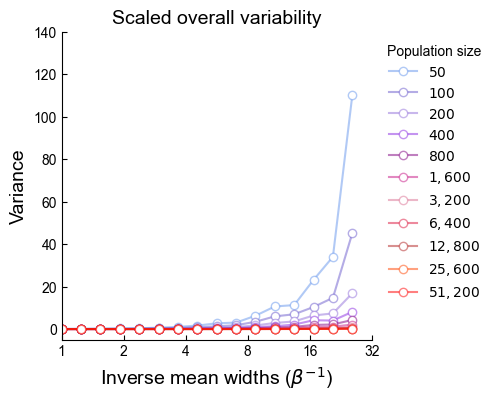

In [59]:
figaxs = [plt.subplots(figsize=(4,4)) for i in range(3)]
for i, n in enumerate(n_neurons):
    col = matplotlib.colors.colorConverter.to_rgba(standard_colors[i], alpha=0.5)
    if i == (len(n_neurons) - 1):
        figaxs[0][1].plot(s_depub[i], '-o', label='${:,}$'.format(int(n)), 
            color=col, markerfacecolor='white', markeredgecolor=col)
    figaxs[1][1].plot(s_avgub[i] * 100, '-o', label='${:,}$'.format(int(n)), 
        color=col, markerfacecolor='white', markeredgecolor=col)
    figaxs[2][1].plot(totalub[i], '-o', label='${:,}$'.format(int(n)), 
        color=col, markerfacecolor='white', markeredgecolor=col)

def format_fig(figax, ylabel, title, figfname, ylim=None, legend=True, sig_samp=None):
    fig, ax = figax
    ax.set_xticks(np.linspace(0, 16, num=power_limit + 1), list(map(lambda x: "{}".format(int(x)), \
               2 ** np.linspace(0, power_limit, num=power_limit + 1))))
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(r'Inverse mean widths ($\beta^{-1}$)', fontsize=14)
    if legend:
        ax.legend(frameon=False, bbox_to_anchor=(1.01, 1), loc='upper left', title='Population size')
    ax.tick_params(direction='in')
    ax.set_xlim((0, 16))
    if ylim:
        ax.set_ylim(ylim)

    ax.spines[['right', 'top']].set_visible(False)

    if g_save_fig:
        fig.savefig('{}__{}'.format(figfname, 'gamma_sims_full_n10_ub_ineff'), dpi=300, bbox_inches='tight')

format_fig(figaxs[0], 'Variance', 'Unscaled boundary effect variability', 'bndry_eff_varpart', ylim=(-5, 200))
figaxs[1][1].set_yscale('log')
format_fig(figaxs[1], 'Variance', 'Unscaled population-size dependent variability', 'n_scale_varpart')
format_fig(figaxs[2], 'Variance', 'Scaled overall variability', 'total_var', ylim=(-5, 140), legend=True)